# Code to Generate Figures

This notebook contains code to create figures similar to those in the paper, "Stochastic Expectation-Maximization for Shuffled Linear Regression" by Abid _et al._, which appeared in the 2018 Allerton Conference. Note that not all of the hyperparameters are the same between the code in this notebook and the figures in the original paper (please see the original paper for the hyperparameters used in the original figures).

In [10]:
import sys, os;
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from utils import *
from algorithms import *

%load_ext autoreload
%matplotlib inline
%autoreload 2

np.set_printoptions(precision=2)
lr =  LinearRegression(fit_intercept=False)

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Figure 2(a)

In [11]:
d = 30
noise = 1
iters = 2
ns = np.linspace(100,500,5,dtype=int)

error_hard = np.zeros((iters,len(ns)))
error_soft = np.zeros((iters,len(ns)))

for i in range(iters):
    print(i, end='| ')
    x_, y__, w0_ = generate_distribution(n=np.max(ns), dim=d,  dist='normal', bias=False, noise=0)
    y_ = y__ + np.random.normal(0,noise,y__.shape)
    for n_i, n in enumerate(ns):
        print(n, end=' ')
        y = y_[:n]; x = x_[:n]
        y = np.random.permutation(y)
        weights = em_mcmc(x,y,steps=50,return_all_weights=True)
        error = calc_error(w0_, weights[-1])
        error_soft[i,n_i] = error

        weights = sls(x,y,steps=50,return_all_weights=True, n_starts=n)
        error = calc_error(w0_, weights[-1])
        error_hard[i,n_i] = error

0| 100 200 

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(ns,np.mean(error_hard,axis=0),'o-',label='Hard')
ax.fill_between(ns,
                np.mean(error_hard,axis=0)-np.std(error_hard,axis=0),
                np.mean(error_hard,axis=0)+np.std(error_hard,axis=0),
                alpha=0.3)
ax.plot(ns,np.mean(error_soft,axis=0),'o-',label='Stochastic')
ax.fill_between(ns,
                np.mean(error_soft,axis=0)-np.std(error_soft,axis=0),
                np.mean(error_soft,axis=0)+np.std(error_soft,axis=0),
                alpha=0.3)
ax.set_ylabel('Inference Error')
ax.set_xlabel('n')
ax.set_title('Inference Error')
ax.legend(fancybox=True, framealpha=0.5,loc='upper left')

# Figure 2(b)

In [ ]:
d = 10
noise = 1
iters = 10
error_hard_sample = np.zeros(iters)
error_soft_sample = np.zeros(iters)

for i in range(iters):
    print(i, end=' ')
    x_, y__, w0_ = generate_distribution(n=250, dim=d,  dist='normal', bias=False, noise=0)
    y_ = y__ + np.random.normal(0,noise,y__.shape)
    y = y_[:n]; x = x_[:n]
    y = np.random.permutation(y)
    weights = em_mcmc(x,y,steps=50,return_all_weights=True)
    error = calc_error(w0_, weights[-1])
    error_soft_sample[i] = error

    weights = sls(x,y,steps=50,return_all_weights=True, n_starts=n)
    error = calc_error(w0_, weights[-1])
    error_hard_sample[i] = error

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(error_hard_sample.squeeze(),error_soft_sample.squeeze(),'ko')

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.set_xlabel('Parameter Error (Hard EM)')
ax.set_ylabel('Parameter Error (Stochastic EM)')

# Figure 3

In [ ]:
n = 250
d = 20
num_steps = 50
iters = 10
step_count = np.linspace(1,num_steps,num_steps)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6), sharey=True)
em_mcmc_average = np.zeros(num_steps)
sls_average = np.zeros(num_steps)
w_baselines = list()
baseline_errors = list()

x, y, w0 = generate_distribution(n=n, dim=d,  dist='normal', bias=False, noise=0)

for i in range(iters):
    print(i, end=' ')
    y_ = np.random.permutation(y)
    w_baseline = lr.fit(x,y_).coef_.reshape(-1,1)
    w_baselines.append(w_baseline)

    weights = em_mcmc(x,y_,steps=num_steps,return_all_weights=True,verbose=False)
    mses = [calc_error(w0, w) for w in weights]
    ax2.plot(step_count, mses,'k-',alpha=0.1)
    em_mcmc_average += mses

    weights= sls(x,y_,steps=num_steps,return_all_weights=True, n_starts=n)
    mses = [calc_error(w0, w) for w in weights]
    ax1.plot(step_count, mses,'k-',alpha=0.1)
    sls_average += mses

ax1.plot(step_count, sls_average/iters,'C0')        
ax2.plot(step_count, em_mcmc_average/iters,'C1')        
ax1.set_title("Hard EM")
ax2.set_title("Stochastic EM") 
ax1.set_xlabel("Step #")
ax1.set_ylabel("Parameter Error at Step")    
ax2.set_xlabel("Step #")
ax2.set_ylabel("Parameter Error at Step")        

# Figure 4

In [12]:
steps = 3
iters = 2
n = 200
d = 10

error_hard_scale = np.zeros((iters, steps))
error_soft_scale = np.zeros((iters, steps))
x, y_, w0_ = generate_distribution(n=n, dim=d,  dist='normal', bias=False, noise=0.3)
w0 = w0_
for i in range(iters):
    print(i, end='| ')
    y = np.copy(y_)
    for s in range(steps):
        print(s, end=' ')
        weights = em_mcmc(x,y,steps=50,return_all_weights=True)
        error = calc_error(w0_, weights[-1])
        error_soft_scale[i,s] = error

        weights = sls(x,y,steps=50,return_all_weights=True, n_starts=n)
        error = calc_error(w0_, weights[-1])
        error_hard_scale[i,s] = error

        for _ in range(5):
            s,t = np.random.permutation(n)[:2]
            y[s], y[t] = y[t], y[s]    

0| 0 1 2 1| 0 1 2 

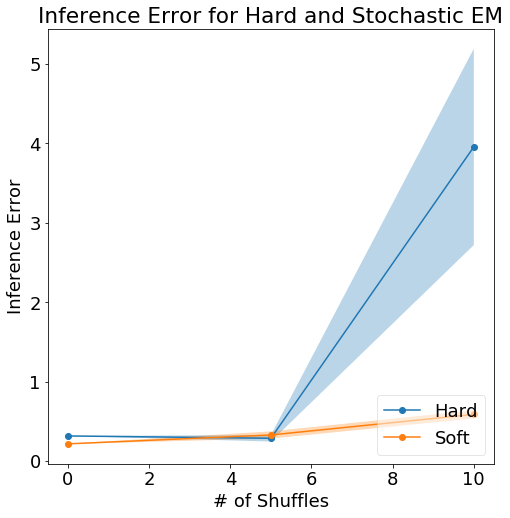

In [13]:
x = 5*np.array(range(steps))
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(x,np.mean(error_hard_scale,axis=0),'o-',label='Hard')
ax.fill_between(x,np.mean(error_hard_scale,axis=0)-np.std(error_hard_scale,axis=0),np.mean(error_hard_scale,axis=0)+np.std(error_hard_scale,axis=0),alpha=0.3)
ax.plot(x,np.mean(error_soft_scale,axis=0),'o-',label='Soft')
ax.fill_between(x,np.mean(error_soft_scale,axis=0)-np.std(error_soft_scale,axis=0),np.mean(error_soft_scale,axis=0)+np.std(error_soft_scale,axis=0),alpha=0.3)
ax.set_ylabel('Inference Error')
ax.set_xlabel('# of Shuffles')
ax.set_title('Inference Error for Hard and Stochastic EM')
ax.legend(fancybox=True, framealpha=0.5,loc='lower right')

# Figure 5(a): Aptamer Dataset

### Load the Datasets

In [14]:
datadir = 'datasets/knight84-training.csv'
f, l, _ = load_dataset_clusters(datadir, n_clusters=1, normalize=True)

i = 0
X = f[i*5000:(i+1)*5000,:]
y = l[i*5000:(i+1)*5000]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
lr.fit(X_train, y_train)
y_ = lr.predict(X_test)
means_ols = (calc_rmse(y_, y_test),calc_rmse(y_, y_test))

### Run the Algorithms

In [15]:
n, d = X_train.shape
n = int(n/4)
n_clusters = [3,4]
fraction_missorted = 0.01
iters = 1
np.random.seed(0)

mse_baseline = np.zeros((iters,len(n_clusters)))
mse_sls = np.zeros((iters,len(n_clusters)))
mse_mcmc = np.zeros((iters,len(n_clusters)))

for j, n_cluster in enumerate(n_clusters):
    print(n_cluster, end='| ')
    for i in range(iters):
        print(i, end=' ')
        features, labels, cluster_vector = shuffle_within_num_groups(X_train, y_train, n_clusters=n_cluster, fraction_missorted=fraction_missorted)

        w = em_mcmc(features,labels, mcmc_steps=int(n*np.log(n)), interval_between_mcmc_steps=n/10, enhanced=True, groups=cluster_vector)
        y_ = X_test.dot(w)
        stoc = calc_rmse(y_, y_test)
        mse_mcmc[i,j] = stoc

        w = sls(features,labels,n_starts=n, enhanced=True, groups=cluster_vector)
        y_ = X_test.dot(w)
        hard = calc_rmse(y_, y_test)
        mse_sls[i,j] = hard

        lr.fit(features, labels)
        y_ = lr.predict(X_test)
        base = calc_rmse(y_, y_test)
        mse_baseline[i,j] = base

3| 0 4| 0 

### Plot the Results

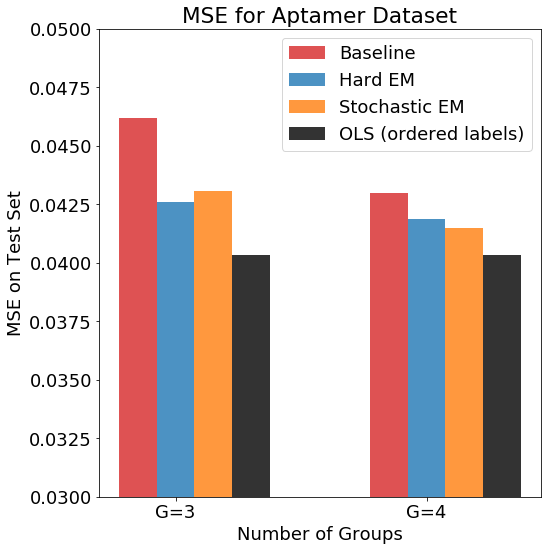

In [16]:
n_groups = 2
means_baseline = (np.mean(mse_baseline[:,0]), np.mean(mse_baseline[:,1]))
std_baseline = (np.std(mse_baseline[:,0]), np.std(mse_baseline[:,1]))
means_hard = (np.mean(mse_sls[:,0]), np.mean(mse_sls[:,1]))
std_hard = (np.std(mse_sls[:,0]), np.std(mse_sls[:,1]))
means_stochastic = (np.mean(mse_mcmc[:,0]), np.mean(mse_mcmc[:,1]))
std_stochastic = (np.std(mse_mcmc[:,0]), np.std(mse_mcmc[:,1]))
means_ols = means_ols
 
# create plot
fig, ax = plt.subplots(figsize=[8,8])
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8
 
rects1 = plt.bar(index, means_baseline, bar_width,
                 alpha=opacity,
                 yerr=std_baseline,
                 color='C3',
                 label='Baseline')
 
rects2 = plt.bar(index + bar_width, means_hard, bar_width,
                 alpha=opacity,
                 yerr=std_hard,
                 label='Hard EM')

rects3 = plt.bar(index + 2*bar_width, means_stochastic, bar_width,
                 alpha=opacity,
                 yerr=std_stochastic,
                 label='Stochastic EM')

rects4 = plt.bar(index + 3*bar_width, means_ols, bar_width,
                 alpha=opacity,
                 color='k',
                 label='OLS (ordered labels)')


plt.xlabel('Number of Groups')
plt.ylabel('MSE on Test Set')
plt.title('MSE for Aptamer Dataset')
plt.xticks(index + bar_width, ('G=3','G=4'))
plt.legend()
plt.ylim([0.03, 0.05])
 
plt.tight_layout()
plt.show()

# Figure 5(b): Boston Housing Dataset

### Load the Dataset

In [17]:
boston = load_boston()
X_ = boston.data
N, D = X_.shape
X = np.ones((N,D+1))
X[:,:-1] = X_
y = boston.target
y = normalize(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
lr.fit(X_train, y_train)
y_ = lr.predict(X_test)
means_ols = calc_rmse(y_, y_test) 

### Run the Algorithms

In [18]:
np.random.seed(0)
n, d = X_train.shape
n_clusters = [3, 4]
iters = 1
f = 2

mse_baseline = np.zeros((iters,len(n_clusters)))
mse_sls = np.zeros((iters,len(n_clusters)))
mse_mcmc = np.zeros((iters,len(n_clusters)))

for j, n_cluster in enumerate(n_clusters):
    print(n_cluster, end='| ')
    for i in range(iters):
        features, labels, cluster_vector = shuffle_within_num_groups_by_feature(X_train, y_train, f, n_clusters=n_cluster)

        w = em_mcmc(features,labels, mcmc_steps=int(n*np.log(n)), interval_between_mcmc_steps=n/10, enhanced=True, groups=cluster_vector)
        y_ = X_test.dot(w)
        stoc = calc_rmse(y_, y_test)
        mse_mcmc[i,j] = stoc

        w = sls(features,labels,n_starts=n, enhanced=True, groups=cluster_vector)
        y_ = X_test.dot(w)
        hard = calc_rmse(y_, y_test)
        mse_sls[i,j] = hard

        lr.fit(features, labels)
        y_ = lr.predict(X_test)
        base = calc_rmse(y_, y_test)
        mse_baseline[i,j] = base

3| 4| 

### Plot the Results

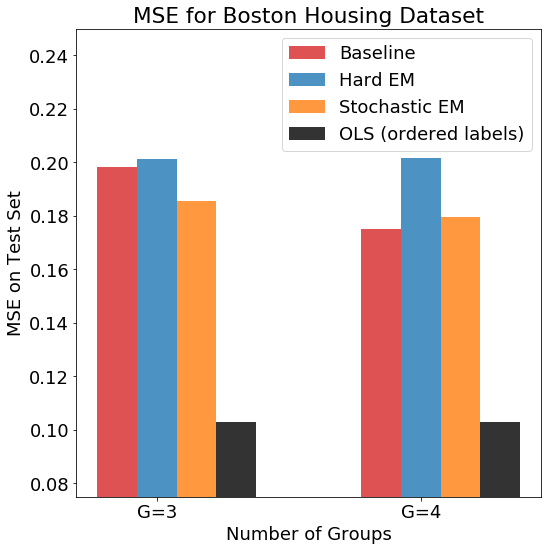

In [20]:
n_groups = 2

means_baseline = (np.mean(mse_baseline[:,0]), np.mean(mse_baseline[:,1]))
std_baseline = (np.std(mse_baseline[:,0]), np.std(mse_baseline[:,1]))
means_hard = (np.mean(mse_sls[:,0]), np.mean(mse_sls[:,1]))
std_hard = (np.std(mse_sls[:,0]), np.std(mse_sls[:,1]))
means_stochastic = (np.mean(mse_mcmc[:,0]), np.mean(mse_mcmc[:,1]))
std_stochastic = (np.std(mse_mcmc[:,0]), np.std(mse_mcmc[:,1]))
means_ols = means_ols
 
# create plot
fig, ax = plt.subplots(figsize=[8,8])
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8
 
rects1 = plt.bar(index, means_baseline, bar_width,
                 alpha=opacity,
                 yerr=std_baseline,
                 color='C3',
                 label='Baseline')
 
rects2 = plt.bar(index + bar_width, means_hard, bar_width,
                 alpha=opacity,
                 yerr=std_hard,
                 label='Hard EM')

rects3 = plt.bar(index + 2*bar_width, means_stochastic, bar_width,
                 alpha=opacity,
                 yerr=std_stochastic,
                 label='Stochastic EM')

rects4 = plt.bar(index + 3*bar_width, means_ols, bar_width,
                 alpha=opacity,
                 color='k',
                 label='OLS (ordered labels)')


plt.xlabel('Number of Groups')
plt.ylabel('MSE on Test Set')
plt.title('MSE for Boston Housing Dataset')
plt.xticks(index + bar_width, ('G='+str(n_clusters[0]),'G='+str(n_clusters[1])))
plt.legend()
plt.ylim([0.075, 0.25])
 
plt.tight_layout()
plt.show()